In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set graphing style
plt.style.use("ggplot")

In [3]:
# Import data
df = pd.read_csv("imdb.csv")

In [4]:
df.head()
# df.shape

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Quick EDA
pos_count = (df["sentiment"] == "positive").value_counts()
print(pos_count)

sentiment
True     25000
False    25000
Name: count, dtype: int64


In [6]:
example = df["review"][50]
print(example)

Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western's Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can't do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got expo

### NLTK

In [7]:
import nltk
nltk.download('punkt_tab')                          # tokenization
nltk.download('averaged_perceptron_tagger_eng')     # parts of speech
nltk.download('maxent_ne_chunker_tab')              # chunking
nltk.download('words')                              # words
nltk.download('vader_lexicon')                      # VADER

[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [Errno 11001] getaddrinfo failed>
[nltk_data] Error loading maxent_ne_chunker_tab: <urlopen error [Errno
[nltk_data]     11001] getaddrinfo failed>
[nltk_data] Error loading words: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [8]:
# Tokenizing review words
tokens = nltk.word_tokenize(example)
tokens[:10]

['Return',
 'to',
 'the',
 '36th',
 'Chamber',
 'is',
 'one',
 'of',
 'those',
 'classic']

In [9]:
# Part of speech tags
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Return', 'NN'),
 ('to', 'TO'),
 ('the', 'DT'),
 ('36th', 'CD'),
 ('Chamber', 'NNP'),
 ('is', 'VBZ'),
 ('one', 'CD'),
 ('of', 'IN'),
 ('those', 'DT'),
 ('classic', 'JJ')]

In [10]:
# Chuncking tags into sentences
entities = nltk.chunk.ne_chunk(tagged[:10])
print(entities)

(S
  (GPE Return/NN)
  to/TO
  the/DT
  36th/CD
  Chamber/NNP
  is/VBZ
  one/CD
  of/IN
  those/DT
  classic/JJ)


### VADER's Model

In [11]:
# VADER sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm      # progress bar

sia = SentimentIntensityAnalyzer()      # sia object

In [12]:
sia.polarity_scores(example)

{'neg': 0.057, 'neu': 0.85, 'pos': 0.094, 'compound': 0.9396}

In [13]:
# Run polarity scores on the entire dataset
result = {}     # dict to store results

# Progress bar
for i, row in tqdm(df.iterrows(), total = len(df)):
    review = row["review"]
    result[i] = sia.polarity_scores(review)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
# Arranging results into a dataframe
vaders = pd.DataFrame(result).T
vaders = pd.concat([df, vaders], axis = 1)
print(vaders)

                                                  review sentiment    neg  \
0      One of the other reviewers has mentioned that ...  positive  0.203   
1      A wonderful little production. <br /><br />The...  positive  0.053   
2      I thought this was a wonderful way to spend ti...  positive  0.094   
3      Basically there's a family where a little boy ...  negative  0.138   
4      Petter Mattei's "Love in the Time of Money" is...  positive  0.052   
...                                                  ...       ...    ...   
49995  I thought this movie did a down right good job...  positive  0.047   
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative  0.166   
49997  I am a Catholic taught in parochial elementary...  negative  0.208   
49998  I'm going to have to disagree with the previou...  negative  0.105   
49999  No one expects the Star Trek movies to be high...  negative  0.135   

         neu    pos  compound  
0      0.748  0.048   -0.9951  
1      0.77

In [15]:
vaders.head()

,review,sentiment,neg,neu,pos,compound
0,One of the other reviewers has mentioned that ...,positive,0.203,0.748,0.048,-0.9951
1,A wonderful little production. <br /><br />The...,positive,0.053,0.776,0.172,0.9641
2,I thought this was a wonderful way to spend ti...,positive,0.094,0.714,0.192,0.9605
3,Basically there's a family where a little boy ...,negative,0.138,0.797,0.065,-0.9213
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.052,0.801,0.147,0.9744


### RoBERTa Pretrained Model

In [19]:
# Hugging face libraries
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
# Using the pretrained model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
# Running the model
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = "pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Dict to store scores
    scores_dict = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }
    return scores_dict

In [24]:
# Run polarity scores on the entire dataset
vader_result = {}     # dict to store results

# Progress bar
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        review = row["review"]
        vader_result[i] = sia.polarity_scores(review)
        
        # Only run on the first 100 rows for quicker analysis
        if i < 100:
            roberta_result = polarity_scores_roberta(review)
        else:
            roberta_result = {}

        # Combining the scores
        both = {**vader_result[i], **roberta_result}
        vader_result[i] = both
        
    # Handling exception errors for some reviews
    except RuntimeError:
        print(f"Broke for id {i}")

  0%|          | 0/50000 [00:00<?, ?it/s]

Broke for id 12
Broke for id 26
Broke for id 29
Broke for id 30
Broke for id 33
Broke for id 48
Broke for id 50
Broke for id 51
Broke for id 58
Broke for id 59
Broke for id 77
Broke for id 92
Broke for id 99


In [25]:
# Arranging results into a dataframe
results_df = pd.DataFrame(vader_result).T
results_df = pd.concat([df, results_df], axis = 1)
results_df.head()

,review,sentiment,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos
0,One of the other reviewers has mentioned that ...,positive,0.203,0.748,0.048,-0.9951,0.339792,0.462738,0.197470
1,A wonderful little production. <br /><br />The...,positive,0.053,0.776,0.172,0.9641,0.004337,0.039048,0.956615
2,I thought this was a wonderful way to spend ti...,positive,0.094,0.714,0.192,0.9605,0.088475,0.263144,0.648381
3,Basically there's a family where a little boy ...,negative,0.138,0.797,0.065,-0.9213,0.755117,0.211640,0.033243
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.052,0.801,0.147,0.9744,0.024546,0.223598,0.751856


### Comparing Model Scores

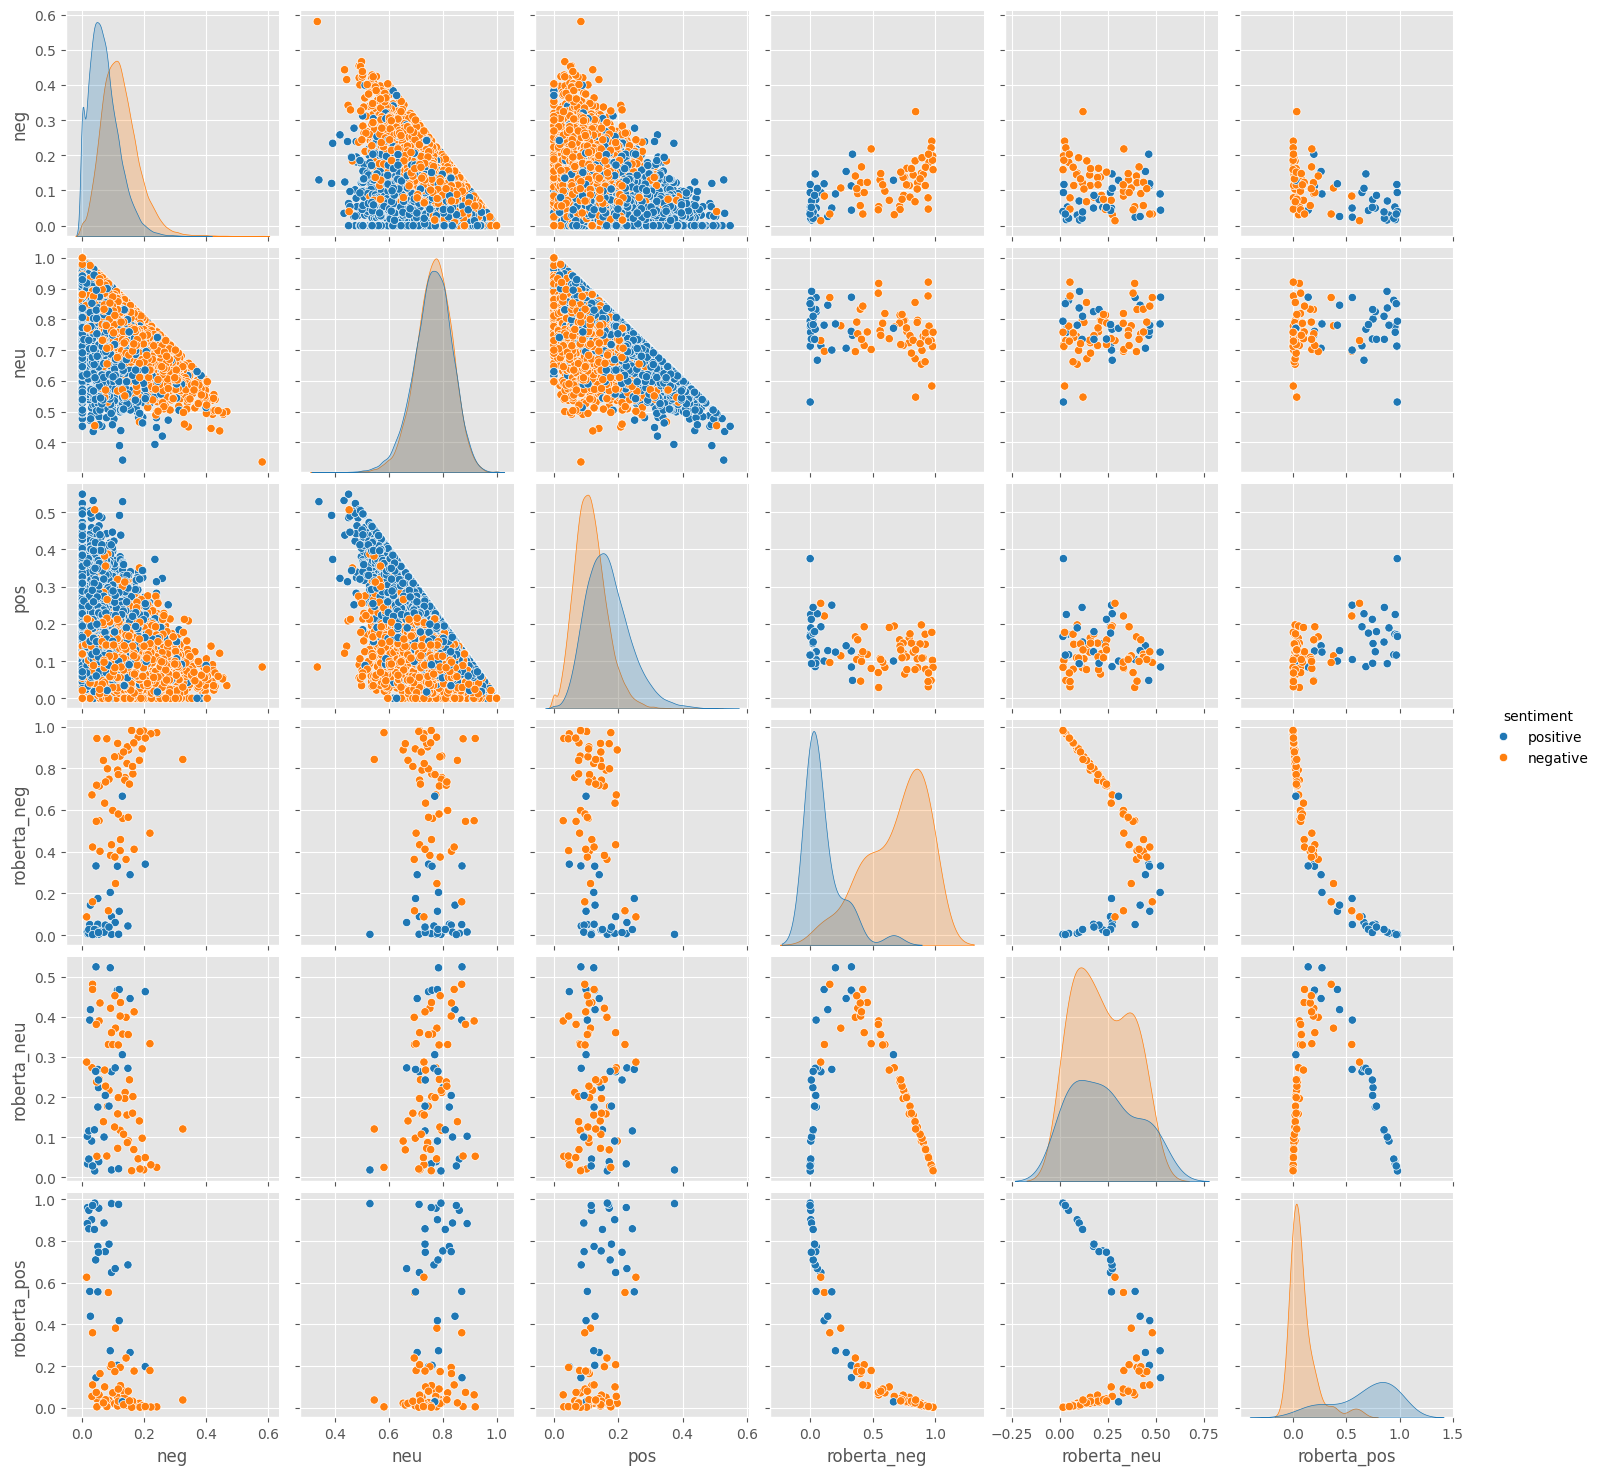

In [34]:
# Pairplot to compare sentimnet vars of both models
sns.pairplot(data = results_df, vars = [
    "neg", "neu", "pos", 
    "roberta_neg", "roberta_neu", "roberta_pos"],
    hue = "sentiment", palette = "tab10"
    )
plt.show()